In [1]:
from matplotlib import pyplot
from pathlib import Path

import gzip
import numpy as np
import pickle
import requests

import torch
import torch.nn.functional as F

from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from pytorch_model_summary import summary
from torch.utils.tensorboard import SummaryWriter

In [2]:
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)
URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

In [3]:
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ( (x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding = "latin-1")

4
(50000, 784)
<class 'numpy.ndarray'>


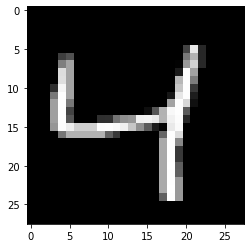

In [4]:
#plot sample numpy array as image
sample_index = 2

pyplot.imshow(x_train[sample_index].reshape((28,28)),cmap="gray")
print(y_train[sample_index])
print(x_train.shape)
print(type(x_train))

In [5]:
#transform numpy into tensors 

x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train,y_train, x_valid, y_valid))
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(type(x_train))
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
<class 'torch.Tensor'>
tensor(0) tensor(9)


In [6]:
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)

In [7]:
def get_data(train_ds, valid_ds, bs):
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
    valid_dl = DataLoader(valid_ds, batch_size=2*bs)

    return (train_dl, valid_dl)

In [8]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    writer = SummaryWriter()
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
        
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums))/np.sum(nums)
        writer.add_scalar('Loss/Val', val_loss, epoch)

        print(epoch, val_loss)

In [9]:
""" 
writer = SummaryWriter()

for n_iter in range(100):
    writer.add_scalar('Loss/train', np.random.random(), n_iter)
    writer.add_scalar('Loss/test', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/train', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/test', np.random.random(), n_iter) """

" \nwriter = SummaryWriter()\n\nfor n_iter in range(100):\n    writer.add_scalar('Loss/train', np.random.random(), n_iter)\n    writer.add_scalar('Loss/test', np.random.random(), n_iter)\n    writer.add_scalar('Accuracy/train', np.random.random(), n_iter)\n    writer.add_scalar('Accuracy/test', np.random.random(), n_iter) "

In [10]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    return loss.item(), len(xb)

In [11]:
#global data
bs = 64

In [12]:
#Broker : avoid hardcoding between data(input schema) & model
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

nn.Sequential
------------------------

``torch.nn`` has another handy class we can use to simplify our code:
`Sequential <https://pytorch.org/docs/stable/nn.html#torch.nn.Sequential>`_ .
A ``Sequential`` object runs each of the modules contained within it, in a
sequential manner. This is a simpler way of writing our neural network.

To take advantage of this, we need to be able to easily define a
**custom layer** from a given function.  For instance, PyTorch doesn't
have a `view` layer, and we need to create one for our network. ``Lambda``
will create a layer that we can then use when defining a network with
``Sequential``.



In [13]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

In [14]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)


In [15]:
# show input shape
print(summary(model, torch.zeros((1, 1, 28, 28)), show_input=True))

# show output shape
print(summary(model, torch.zeros((1, 1, 28, 28)), show_input=False))

---------------------------------------------------------------------------
          Layer (type)         Input Shape         Param #     Tr. Param #
              Conv2d-1      [1, 1, 28, 28]             160             160
                ReLU-2     [1, 16, 14, 14]               0               0
              Conv2d-3     [1, 16, 14, 14]           2,320           2,320
                ReLU-4       [1, 16, 7, 7]               0               0
              Conv2d-5       [1, 16, 7, 7]           1,450           1,450
                ReLU-6       [1, 10, 4, 4]               0               0
   AdaptiveAvgPool2d-7       [1, 10, 4, 4]               0               0
              Lambda-8       [1, 10, 1, 1]               0               0
Total params: 3,930
Trainable params: 3,930
Non-trainable params: 0
---------------------------------------------------------------------------
---------------------------------------------------------------------------
          Layer (type)       

In [16]:
#plot model
writer = SummaryWriter()
bs=64
images=torch.zeros((bs, 1, 28, 28))
writer.add_graph(model, images)
writer.close()

In [18]:
#global model & training
loss_func = F.cross_entropy
lr = 0.5  # learning rate
epochs =10

In [19]:
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [20]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.35383519942760466
1 0.26855025696754453
2 0.2184499575614929
3 0.3107086269378662
4 0.2367615327358246
5 0.24088893311023712
6 0.2063563416481018
7 0.21391916857361792
8 0.22723939158916473
9 0.22063720114231108


In [21]:
print(torch.cuda.is_available())

True


In [22]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")
print(dev)

cuda
